# Análisis del dataset de entrenamiento


In [1]:
import pandas as pd
import numpy as np
import random
import os
import copy
import math

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
WORDCLOUD_SEED = 37
RANDOM_SEED = 29

random.seed(RANDOM_SEED)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\danny\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 1. Análisis de frecuencia de palabras


En textos de de humor es común que se sigan ciertos patrones o se utilicen ciertas palabras con sentido de humor como "JAJA" o "#humor" que los modelos pueden asociar erróneamente a niveles de humor durante el finetuning. También pueden haber palabras poco frecuentes entre la clases humor y no humor que el modelo pueden aprender a asociar a estas clases.

El objetivo de este análisis es extender el dataset de entrenamiento con instancias que incluyan estas palabras con sentido de humor para hacer más resistente el modelo a estos patrones y mejorar su rendimiento en las tareas de detección y clasificación. También se quiere evaluar el impacto de las palabras de humor del dataset de entrenamiento en el dataset de evaluación.

### 1.1. Dataset de entrenamiento

En esta sección se realiza un análisis de frecuencia de palabras por cada clase en el dataset de entrenamiento ubicado en la ruta `./data/processed/haha_train.csv` para identificar las palabras más frecuentes, poco frecuentes y con sentido de humor por clase.

In [4]:
train_processed_file_path = '../data/processed/haha_train.csv'

train_processed_df = pd.read_csv(train_processed_file_path, sep=',', encoding='utf-8')

train_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    24000 non-null  object
 1   score   24000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 375.1+ KB


In [5]:
print("Train Processed Dataset - Cantidad de textos por clase:")
text_counts = train_processed_df['score'].value_counts()
text_counts = text_counts.sort_index()
pd.DataFrame(text_counts)

Train Processed Dataset - Cantidad de textos por clase:


count
score       
0      14766
1       3005
2       2337
3       2412
4       1168
5        312

In [6]:
score_classes = [0, 1, 2, 3, 4, 5]
score_classes

[0, 1, 2, 3, 4, 5]

In [7]:
detection_classes = [0, 1]
detection_classes

[0, 1]

In [8]:
def custom_tokenizer(text):
  # Regex para hacer match de hashtags, emojis, y palabras.
  pattern = r"(\#[a-zA-Z0-9_]+|[^\w\s,]|[\w]+|[\U00010000-\U0010ffff])"
  return re.findall(pattern, text)

Se define un conjunto de palabras o partes de palabras con significado relacionado a humor, como sinónimos o antónimos de humor, modos de humor, hashtags relacionados con humor, acrónimos de humor, algunas palabras comunes en inglés de humor y algunos emojis que expresa sentimiento de humor.


In [9]:
HUMOR_WORDS_EXACT = ["risa", "reír", "ríe", "riendo", "joda", "colmo",
                     "meme", "fun", "funny", "comedy", "cringe", "random",
                     "irony", "sarcasm", "satire", "parody",
                     "LOL"]
HUMOR_WORDS_PARTIAL = ["jaja", "jajá", "haha", "bromear", "carcajada", "partirse", "mofarse", "reírse", "riéndose", "reiría",
                       "humor", "humorista", "chiste", "broma", "bromista", "comedia", "burla", "burlándose", "chanza",
                       "parodia", "chascarrillo", "cachondeo", "guasa",
                       "gracioso", "graciosa", "divertido", "divertida", "diversión", "payasada",
                       "sarcasmo", "sarcástico", "ironía", "irónico", "sátira", "satírico", "parodia",
                       "#meme" "#fun", "#funny", "#comedy", "#cringe", "#irony", "#sarcasm", "#satire", "#parody", "#random",
                       "joke", "kidding", "mocking", "laugh", "smile", "hilarious", "humorous", "random",
                       "LMAO", "ROFL", "XD", "OMG",
                       "😀", "😊", "😆", "😁", "😂", "🤣",
                       "🤔", "😅", "😩",
                       "☹️", "😞", "😔", "🥺", "😢", "😭"]

In [10]:
def container_humor_words(token: str) -> bool:
  result = False
  token1 = token.lower()

  humor_words_exact_lower = [word.lower() for word in HUMOR_WORDS_EXACT]

  for word in humor_words_exact_lower:
    if word == token1:
      result = True
      return result

  humor_words_partial_lower = [word.lower() for word in HUMOR_WORDS_PARTIAL]

  for word in humor_words_partial_lower:
    if word in token1:
      result = True
      return result

  return result

In [11]:
def get_tokens_per_class(data_df: pd.DataFrame,
                         classes_list: list[str],
                         k=200) -> dict:
  """
  Obtiene conjuntos de tokens completo y tokens de humor por clase.
  """

  result = {}
  is_detection = len(classes_list) == 2

  for score_class in classes_list:
    if score_class == 1 and is_detection:
      partition_df = data_df[data_df['score'] >= score_class]
    else:
      partition_df = data_df[data_df['score'] == score_class]
    
    text_values = partition_df['text'].to_list()

    tokens = [custom_tokenizer(text) for text in text_values]
    tokens = [token for token_list in tokens for token in token_list]

    freq_dist = FreqDist(tokens)
    unique_tokens = list(freq_dist.keys())

    most_common = freq_dist.most_common()

    most_freq_dist = most_common[:k]
    most_freq_tokens = [token for token, _ in most_freq_dist]

    least_freq_dist = most_common[:-k:-1]
    least_freq_tokens = [token for token, _ in least_freq_dist]

    humor_tokens = [token for token in unique_tokens if container_humor_words(token)]

    result[score_class] = {
        'tokens': tokens,
        'unique_tokens': unique_tokens,
        'most_freq_tokens': most_freq_tokens,
        'least_freq_tokens': least_freq_tokens,
        'humor_tokens': humor_tokens
    }

  return result

In [12]:
tokens_per_class_train = get_tokens_per_class(train_processed_df, score_classes, k=5000)

In [13]:
def plot_wordclouds(tokens_per_class: dict,
                    classes_list: list[str],
                    tokens_set='tokens',
                    max_words=200):
  """
  Muestra las nubes de tokens para cada clase.
  """

  is_detection = len(classes_list) == 2

  if is_detection:
    fig, axes = plt.subplots(1, 2, figsize=(6, 5))
  else:
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))

  for i, score_class in enumerate(classes_list):
    wc_text = ' '.join(tokens_per_class[score_class][tokens_set])
    wordcloud = WordCloud(width=400,
                          height=400,
                          background_color='white',
                          collocations=True,
                          random_state=WORDCLOUD_SEED,
                          max_words=max_words).generate(wc_text)
    
    if is_detection:
      x = i // 2
      y = i % 2
      axes[y].imshow(wordcloud, interpolation='bilinear')
      axes[y].axis('off')
      axes[y].set_title(f'Score {score_class}', fontsize=18)
    else:
      x = i // 3
      y = i % 3
      axes[x, y].imshow(wordcloud, interpolation='bilinear')
      axes[x, y].axis('off')
      axes[x, y].set_title(f'Score {score_class}', fontsize=18)

  plt.tight_layout()
  plt.show()

En el siguiente gráfico se muestran algunas palabras comunes encontradas por cada clase.

Nubes de tokens por clase:


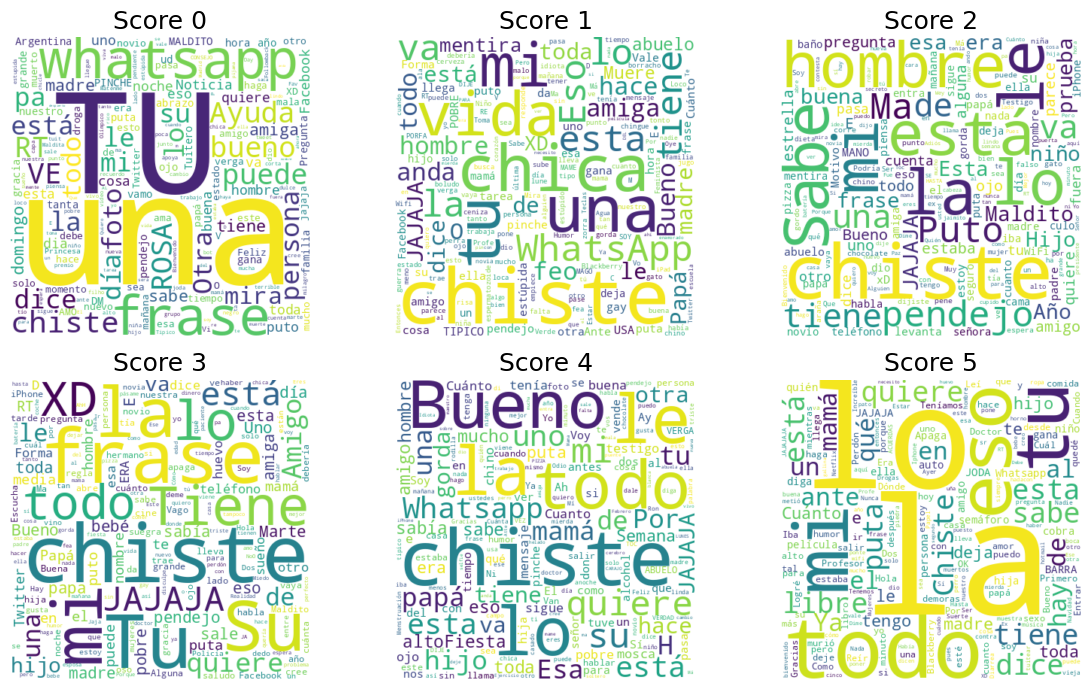

In [14]:
print("Nubes de tokens por clase:")
plot_wordclouds(tokens_per_class_train, score_classes, tokens_set='unique_tokens')

En el siguiente gráfico se muestran algunas de las palabras menos frecuentes encontradas por cada clase.

Nubes de tokens menos frecuentes por clase:


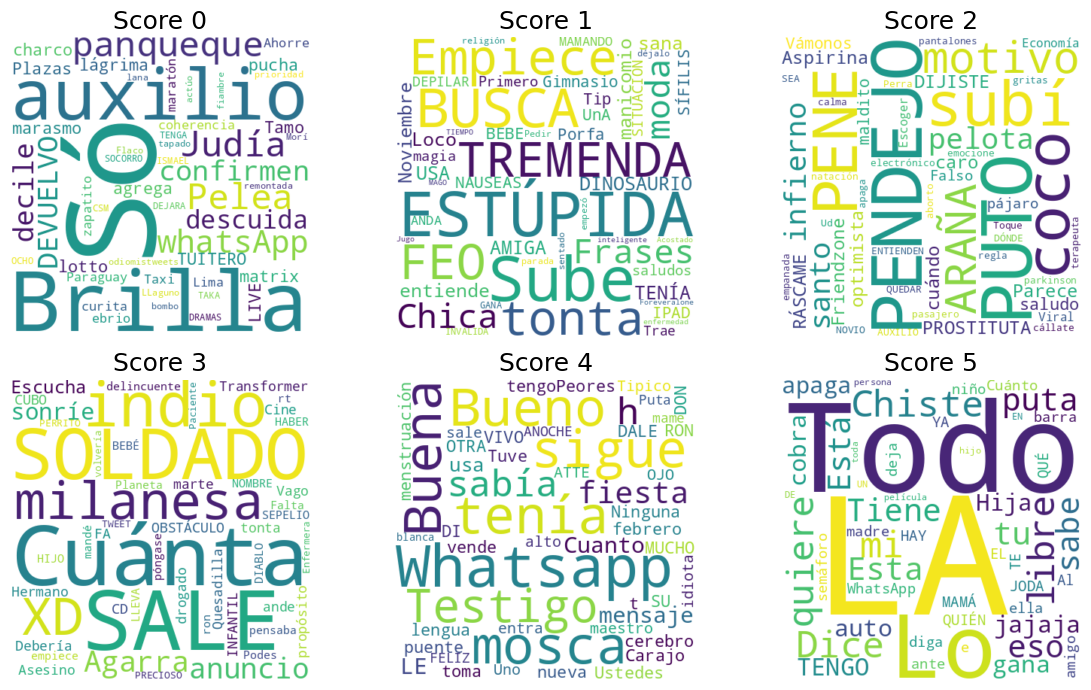

In [15]:
print("Nubes de tokens menos frecuentes por clase:")
plot_wordclouds(tokens_per_class_train, score_classes, tokens_set='least_freq_tokens', max_words=50)

En el siguiente gráfico se muestran algunas de las palabras más frecuentes encontradas por cada clase.

Nubes de tokens más frecuentes por clase:


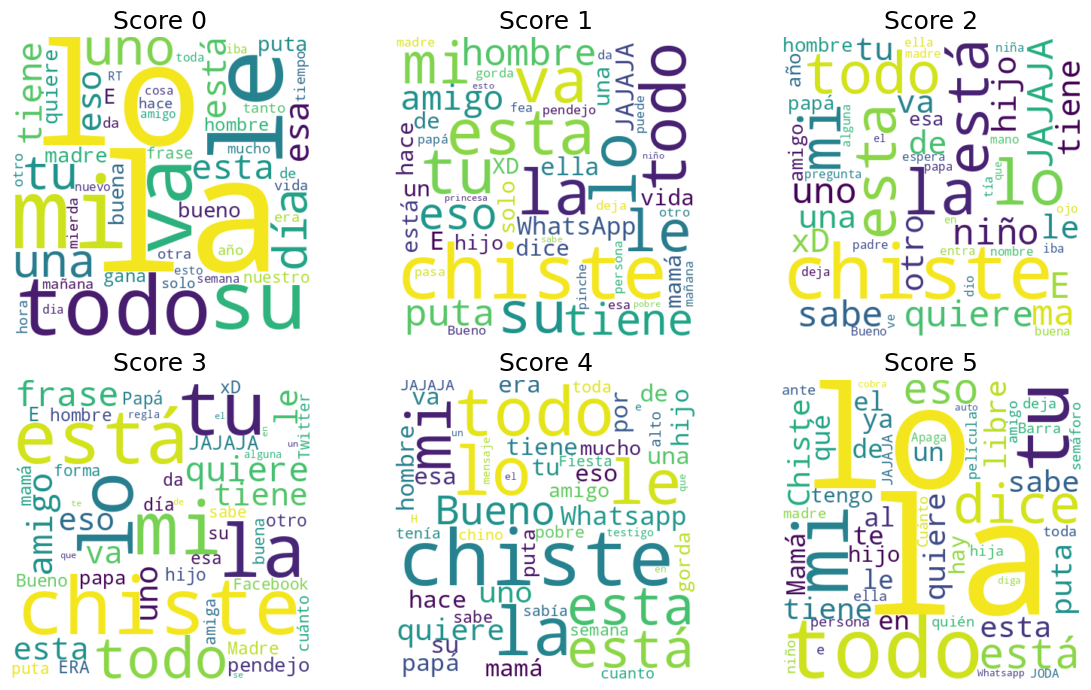

In [16]:
print("Nubes de tokens más frecuentes por clase:")
plot_wordclouds(tokens_per_class_train, score_classes, tokens_set='most_freq_tokens', max_words=50)

En el siguiente gráfico se muestran las palabras asociadas a humor encontradas por cada clase.

Nubes de tokens de humor presentes por clase:


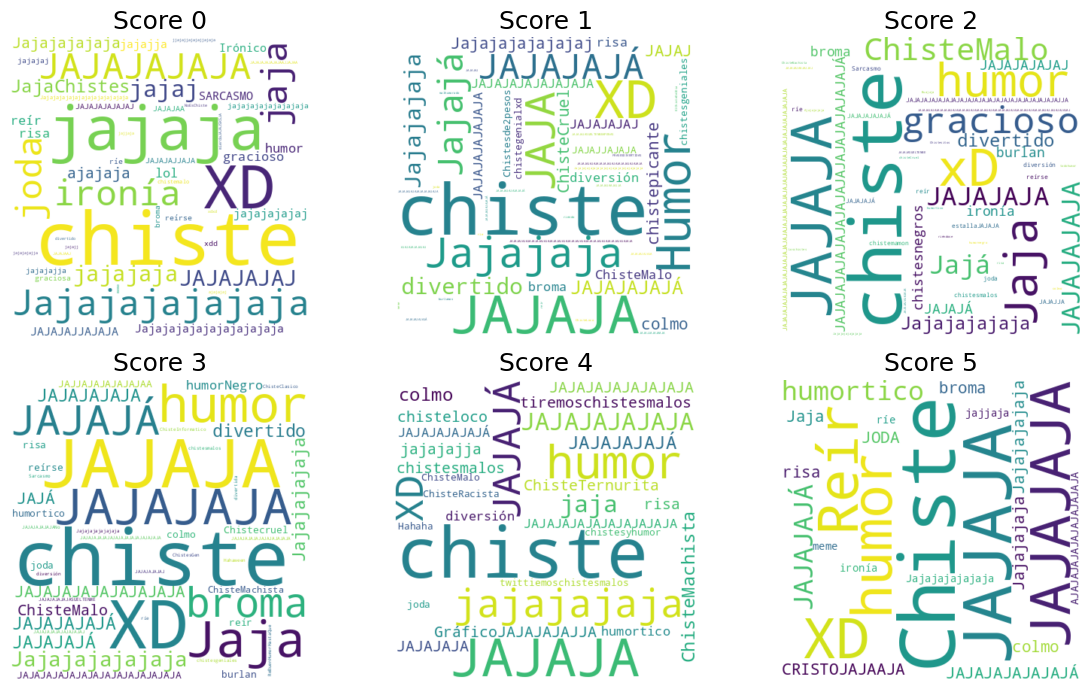

In [17]:
print("Nubes de tokens de humor presentes por clase:")
plot_wordclouds(tokens_per_class_train, score_classes, tokens_set='humor_tokens', max_words=50)

In [18]:
all_humor_tokens_train = []
for score_class in score_classes:
  all_humor_tokens_train.extend(tokens_per_class_train[score_class]['humor_tokens'])

all_humor_tokens_train = list(set(all_humor_tokens_train))

print(f"Tokens de humor encontrados: {len(all_humor_tokens_train)}")

Tokens de humor encontrados: 357


Se encuentran un 357 tokens distintos en el dataset con significado de humor como 'chiste', 'jajajá' o 'humor'.

A continuación se calculará el porcentaje de instancias en el dataset con y sin estos tokens de humor para cada clase según la tarea detección o clasificación.

In [19]:
def count_humor_tokens(text):
  count = 0
  tokens = custom_tokenizer(text)
  for token in tokens:
    if container_humor_words(token):
      count += 1

  return count

In [20]:
train_processed_df2 = train_processed_df.copy()
train_processed_df2['humor_tokens'] = train_processed_df2['text'].apply(lambda col: count_humor_tokens(col))

no_humor_counts_train = train_processed_df2[train_processed_df2['humor_tokens'] == 0]
no_humor_counts_train = no_humor_counts_train['score'].value_counts()
no_humor_counts_train = no_humor_counts_train.sort_index()

humor_counts_train = train_processed_df2[train_processed_df2['humor_tokens'] > 0]
humor_counts_train = humor_counts_train['score'].value_counts()
humor_counts_train = humor_counts_train.sort_index()

In [21]:
def plot_bars_humor_tokens(no_humor_counts: pd.Series,
                           humor_counts: pd.Series,
                           classes_list: list[str],
                           fix_y_pos=True):
  """
  Presenta un gráfico de barras apilado para conteos de textos con/sin tokens de humor en el dataset.
  """
  total_counts = humor_counts + no_humor_counts
  no_humor_percentages = no_humor_counts / total_counts * 100
  humor_percentages = humor_counts / total_counts * 100

  bottom = pd.Series([0]*len(classes_list))

  figsize = (5, 5) if len(classes_list) == 2 else (8, 5)
  plt.figure(figsize=figsize)
  plt.bar(classes_list, no_humor_counts, bottom=bottom, color='skyblue', label='Instancias sin tokens de humor')

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + no_humor_counts[score_class]/2
    if fix_y_pos:
      y = 500 if y < 300 else y
    label = f'{no_humor_counts[score_class]:,} ({no_humor_percentages[score_class]:.1f}%)'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

  bottom += no_humor_counts
  plt.bar(classes_list, humor_counts, bottom=bottom, color='orange', label='Instancias con tokens de humor')

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + humor_counts[score_class]/2
    if fix_y_pos:
      y = 1000 if y < 400 else y
    label = f'{humor_counts[score_class]:,} ({humor_percentages[score_class]:.1f}%)'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black')

  bottom += humor_counts
  max_bottom = np.max([bottom[score_class] for score_class in classes_list])

  for score_class in classes_list:
    x = score_class
    y = bottom[score_class] + max_bottom*0.02
    if fix_y_pos:
      y = 1600 if y < 1500 else y
    label = f'{total_counts[score_class]:,}'
    plt.text(x, y, label, ha='center', va='center', fontsize=9, color='black', fontweight='bold')

  plt.xticks(classes_list)
  plt.xlabel('Clases')
  plt.ylabel('Instancias')
  task = 'Detección' if len(classes_list) == 2 else 'Clasificación'
  title = f'{task} - Instancias con/sin tokens de humor por clase'
  plt.title(title)
  plt.legend()
  plt.tight_layout()
  plt.show()

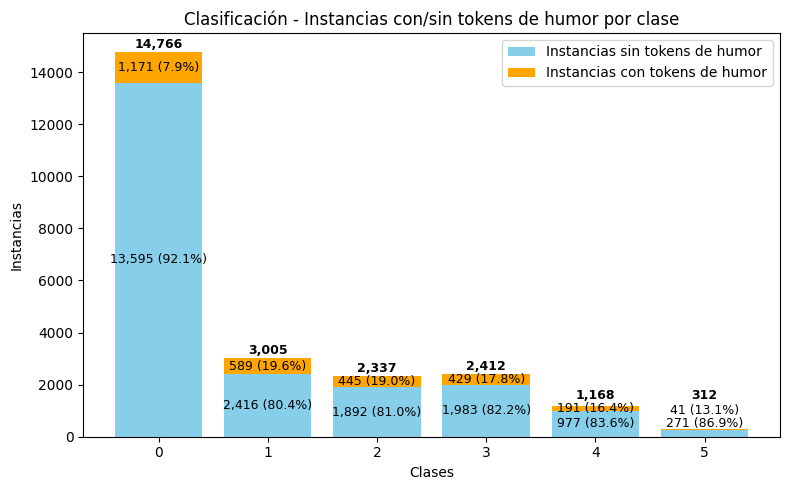

In [22]:
plot_bars_humor_tokens(no_humor_counts_train, humor_counts_train, score_classes)

Para la tarea de clasificación, de las instancias etiquetadas con un nivel de humor (del 1 al 5), entre un 14% al 19% aproximadamente tienen tokens de humor.


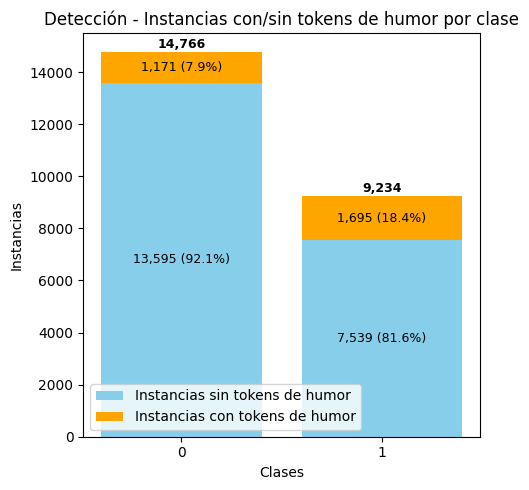

In [23]:
humor_counts_train2 = pd.Series([humor_counts_train.iloc[0], humor_counts_train.iloc[1:].sum()], index=[0, 1])
no_humor_counts_train2 = pd.Series([no_humor_counts_train.iloc[0], no_humor_counts_train.iloc[1:].sum()], index=[0, 1])

plot_bars_humor_tokens(no_humor_counts_train2, humor_counts_train2, detection_classes)

Para la tarea de detección, de las instancias etiquetadas como humor (clase 1), el 18% tienen tokens de humor.


### 1.2. Dataset de evaluación para detección

En esta sección se realiza un análisis de frecuencia de palabras por cada clase en el dataset de evaluación para la tarea de detección ubicado en la ruta `./data/detection/test.csv` para identificar las palabras más frecuentes, poco frecuentes y con sentido de humor por clase.

In [24]:
test_detection_file_path = '../data/detection/test.csv'

test_detection_df = pd.read_csv(test_detection_file_path, sep=',', encoding='utf-8')

test_detection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991 entries, 0 to 1990
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1991 non-null   object
 1   score   1991 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.2+ KB


In [25]:
print("Test Detection Dataset - Cantidad de textos por clase:")
text_counts2 = test_detection_df['score'].value_counts()
text_counts2 = text_counts2.sort_index()
pd.DataFrame(text_counts2)

Test Detection Dataset - Cantidad de textos por clase:


count
score       
0        813
1       1178

In [26]:
tokens_per_class_test = get_tokens_per_class(test_detection_df, detection_classes)

En el siguiente gráfico se muestran algunas palabras comunes encontradas por cada clase.

Nubes de tokens por clase:


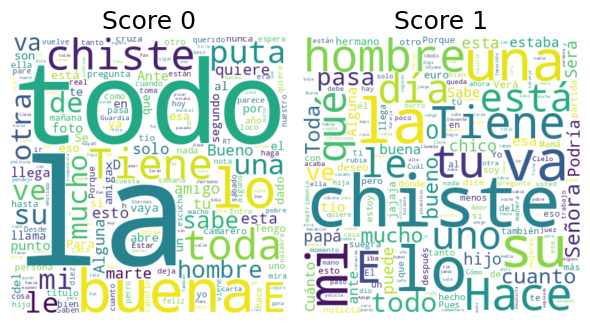

In [27]:
print("Nubes de tokens por clase:")
plot_wordclouds(tokens_per_class_test, detection_classes, tokens_set='unique_tokens')

En el siguiente gráfico se muestran algunas de las palabras menos frecuentes encontradas por cada clase.

Nubes de tokens menos frecuentes por clase:


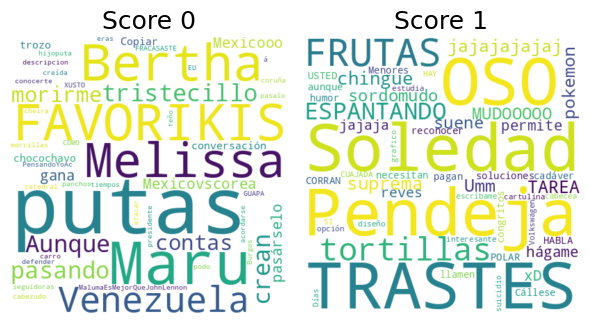

In [28]:
print("Nubes de tokens menos frecuentes por clase:")
plot_wordclouds(tokens_per_class_test, detection_classes, tokens_set='least_freq_tokens', max_words=50)

En el siguiente gráfico se muestran algunas de las palabras más frecuentes encontradas por cada clase.

Nubes de tokens más frecuentes por clase:


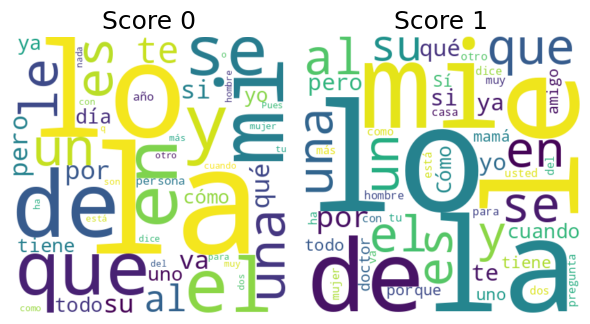

In [29]:
print("Nubes de tokens más frecuentes por clase:")
plot_wordclouds(tokens_per_class_test, detection_classes, tokens_set='most_freq_tokens', max_words=50)

En el siguiente gráfico se muestran las palabras asociadas a humor encontradas por cada clase.

Nubes de tokens de humor presentes por clase:


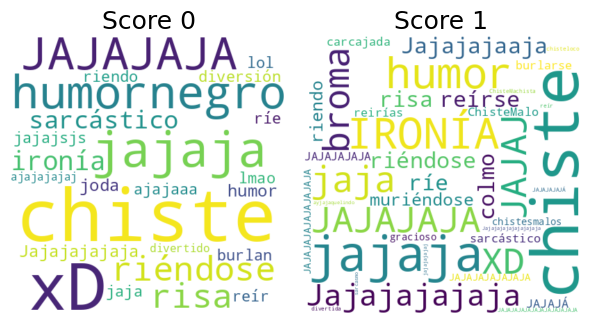

In [30]:
print("Nubes de tokens de humor presentes por clase:")
plot_wordclouds(tokens_per_class_test, detection_classes, tokens_set='humor_tokens', max_words=50)

In [31]:
all_humor_tokens_test = []
for score_class in detection_classes:
  all_humor_tokens_test.extend(tokens_per_class_test[score_class]['humor_tokens'])

all_humor_tokens_test = list(set(all_humor_tokens_test))

print(f"Tokens de humor encontrados: {len(all_humor_tokens_test)}")

Tokens de humor encontrados: 84


Se encuentran un 84 tokens distintos en el dataset con significado de humor como 'chiste', 'jajajá' o 'humor'.

In [32]:
test_detection_df2 = test_detection_df.copy()
test_detection_df2['humor_tokens'] = test_detection_df2['text'].apply(lambda col: count_humor_tokens(col))

no_humor_counts_test = test_detection_df2[test_detection_df2['humor_tokens'] == 0]
no_humor_counts_test = no_humor_counts_test['score'].value_counts()
no_humor_counts_test = no_humor_counts_test.sort_index()

humor_counts_test = test_detection_df2[test_detection_df2['humor_tokens'] > 0]
humor_counts_test = humor_counts_test['score'].value_counts()
humor_counts_test = humor_counts_test.sort_index()

A continuación se calculará el porcentaje de instancias en el dataset con y sin estos tokens de humor para cada clase según la tarea detección.

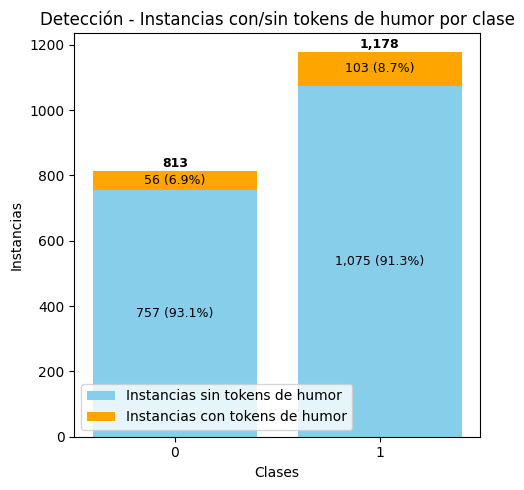

In [33]:
plot_bars_humor_tokens(no_humor_counts_test, humor_counts_test, detection_classes, False)

Para la tarea de detección, de las instancias etiquetadas como humor (clase 1), el 8.7% tienen tokens de humor.

## 2. Análisis de longitud de textos


En esta sección del notebook se hace un análisis de las longitudes de los textos en cada clase.

### 2.1. Dataset de entrenamiento

In [34]:
train_processed_df3 = train_processed_df.copy()
train_processed_df3['length'] = train_processed_df2['text'].str.len()

In [35]:
def get_stats_per_class(data_df: pd.DataFrame, classes_list: list[str]) -> dict:
  """
  Calcula las estatísticas de las longitudes de los textos en el dataset.
  """
  stats_per_class = {}
  for score_class in classes_list:
    partition_df = data_df[data_df['score'] == score_class]
    stats_per_class[score_class] = {
      'mean': partition_df['length'].mean(),
      'std': partition_df['length'].std(),
      'min': partition_df['length'].min(),
      'max': partition_df['length'].max()
    }

  return stats_per_class

In [36]:
stats_per_class_train = get_stats_per_class(train_processed_df3, score_classes)

pd.DataFrame([
    {'class': k, 'mean': v['mean'], 'std': v['std'], 'min': v['min'], 'max': v['max']}
    for k, v in stats_per_class_train.items()
])

class       mean        std  min  max
0      0  68.311188  35.306490    1  152
1      1  99.346090  30.875152   10  166
2      2  99.819855  30.022332   11  156
3      3  99.209784  30.206725   23  153
4      4  98.339041  30.412724   20  154
5      5  95.878205  32.046859   25  149

In [37]:
def plot_histogram_text_lengths(data_df: pd.DataFrame, bins=10, class_label='0'):
  """
  Presenta un histograma de las longitudes de textos.
  """
  plt.figure(figsize=(8, 5))
  plt.hist(data_df['length'], bins=bins, color='firebrick', edgecolor='firebrick')
  title = f'Distribución de las longitudes de textos (Clase {class_label})'
  plt.title(title)
  plt.xlabel('Longitud de textos (caracteres)')
  plt.ylabel('Frecuencia')
  plt.grid(True)
  plt.show()

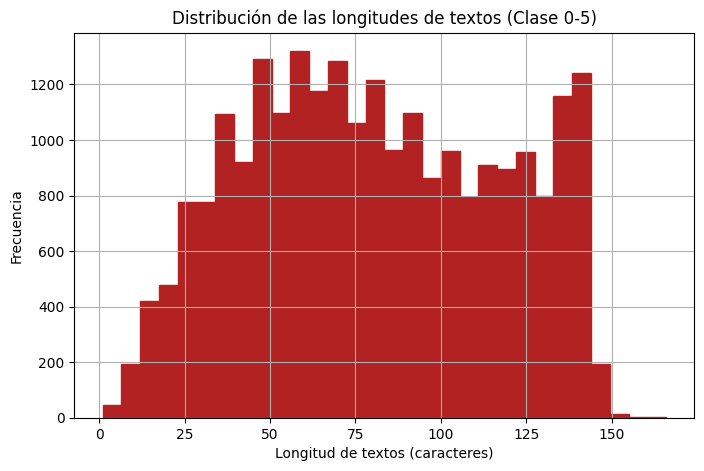

In [38]:
plot_histogram_text_lengths(train_processed_df3, bins=30, class_label='0-5')

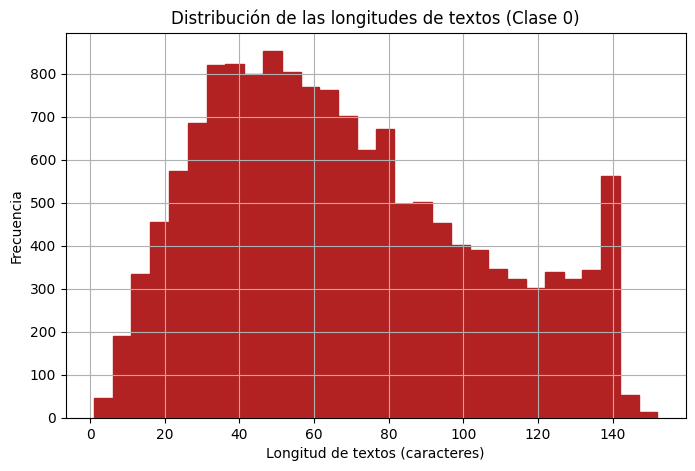

In [39]:
negative_lengths_df = train_processed_df3[train_processed_df3['score'] == 0]

plot_histogram_text_lengths(negative_lengths_df, bins=30, class_label='0')

Del histograma se observa que la mayoría de textos clasificados como no humor (clase 0) tienen una longitud entre 20 y 100 caracteres. Algunos textos de longitud superior a 120 caracteres fueron etiquetados sin humor. Los textos clasificados como no humor tienden a ser de tamaño pequeño o medio.


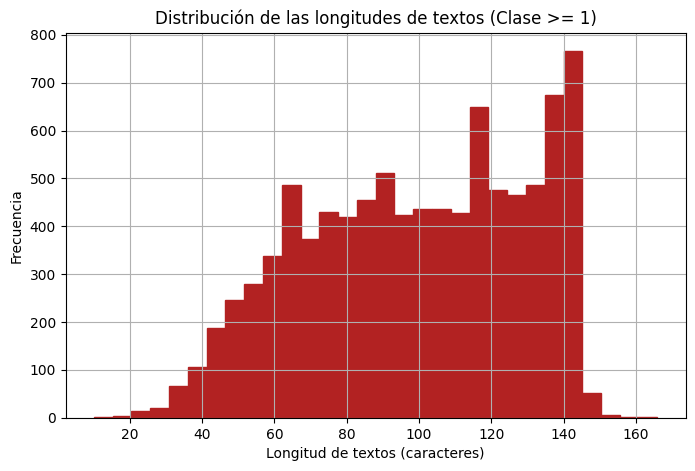

In [40]:
positive_lengths_df = train_processed_df3[train_processed_df3['score'] >= 1]

plot_histogram_text_lengths(positive_lengths_df, bins=30, class_label='>= 1')

Del histograma se observa que muchos textos de longitudes grandes superiores a 80 caracteres fueron etiquetados con algún nivel de humor (del 1 al 5). Los textos clasificados como humor tienden a ser de tamaño medio y largo.


### 2.2. Dataset de evaluación para detección

In [41]:
test_detection_df3 = test_detection_df.copy()
test_detection_df3['length'] = test_detection_df3['text'].str.len()

In [42]:
stats_per_class_test = get_stats_per_class(test_detection_df3, detection_classes)

pd.DataFrame([
    {'class': k, 'mean': v['mean'], 'std': v['std'], 'min': v['min'], 'max': v['max']}
    for k, v in stats_per_class_test.items()
])

class        mean         std  min   max
0      0  126.789668  186.246933    6  2631
1      1  221.074703  254.085385   30  2599

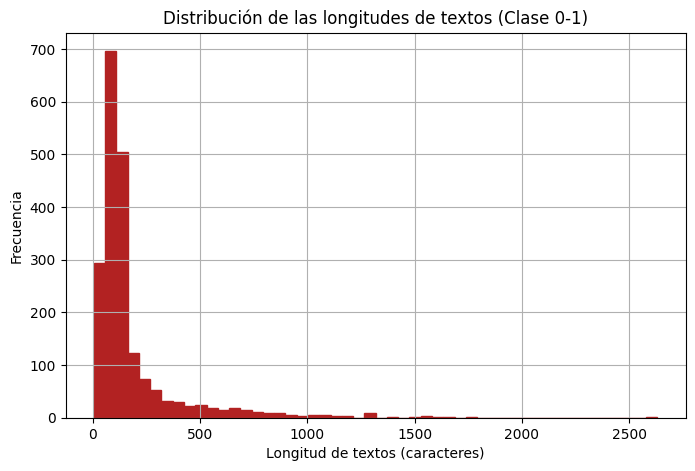

In [43]:
plot_histogram_text_lengths(test_detection_df3, bins=50, class_label='0-1')

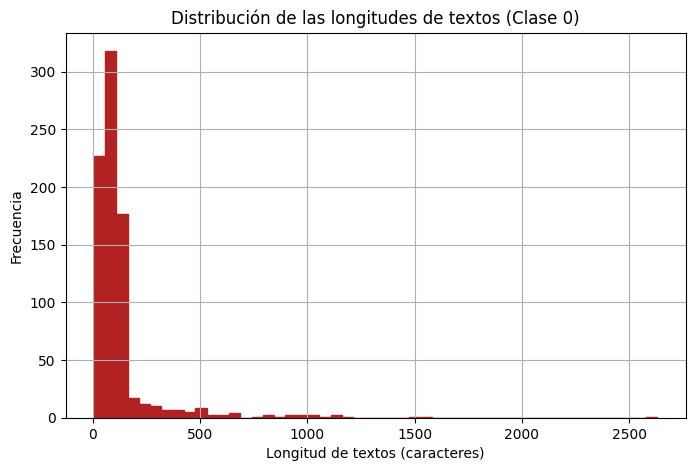

In [44]:
negative_lengths_df = test_detection_df3[test_detection_df3['score'] == 0]

plot_histogram_text_lengths(negative_lengths_df, bins=50, class_label='0')

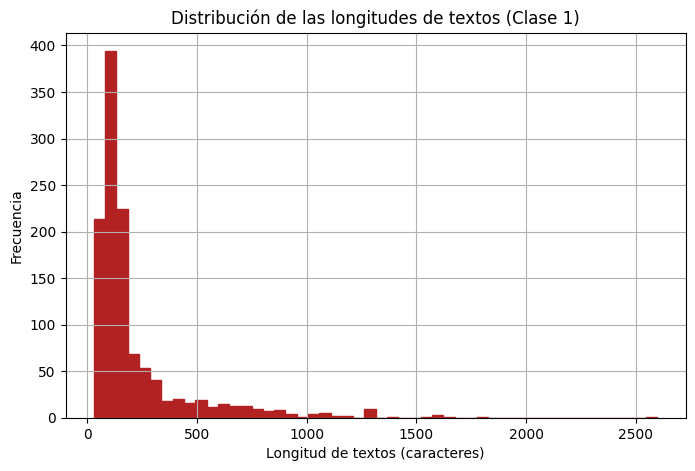

In [45]:
positive_lengths_df = test_detection_df3[test_detection_df3['score'] == 1]

plot_histogram_text_lengths(positive_lengths_df, bins=50, class_label='1')

De los histogramas se observa que ambas clases no humor 0 y humor 1 tienen una distribución similar donde la gran mayoría de textos se concentran en longitudes menores a 250 caracteres aproximadamente.

## 3. Generación de dataset sintético


### 3.1. Dataset sintético con tokens de humor


Se genera un dataset sintético de 2000 instancias de tamaño aleatorio, con tokens de humor junto con tokens seleccionados del vocabulario, clasificados como no humor (clase 0). Los pasos para cosntruir el dataset son:

- Se fija un tamaño de texto aleatorio entre los límites A y B.
- Seleccionar K tokens del conjunto total de tokens de humor y concatenarlo con los siguientes tokens.
- Seleccionar tokens del conjunto de tokens únicos de clase no humor 0 y concatenarlos hasta alcanzar el tamaño de texto fijado.
- Todos los textos se marcan como clase no humor 0.

El objetivo es generar un dataset que equilibre la proporción de instancias de textos con/sin tokens de humor.

In [46]:
humor_unique_tokens_train = []
for score_class in score_classes[1:]:
  humor_unique_tokens_train.extend(tokens_per_class_train[score_class]['unique_tokens'])

humor_unique_tokens_train = list(set(humor_unique_tokens_train))

print(f"Tokens únicos de Clase >= 1: {len(humor_unique_tokens_train)}")

Tokens únicos de Clase >= 1: 22082


In [47]:
no_humor_unique_tokens_train = tokens_per_class_train[0]['unique_tokens']

print(f"Tokens únicos de Clase 0: {len(no_humor_unique_tokens_train)}")

Tokens únicos de Clase 0: 29396


In [48]:
def generate_humor_synthetic_df(all_humor_tokens: list[str],
                                no_humor_unique_tokens: list[str],
                                k=1,
                                length_limits=(10, 30),
                                rows=10) -> pd.DataFrame:
  """
  Genera un DataFrame de textos sintéticos con tokens de humor y tokens del vocabulario
  de la clase no humor 0.
  """
  
  data = []

  for _ in range(rows):
    target_length = random.randint(length_limits[0], length_limits[1])
    random_humor_tokens = random.sample(all_humor_tokens, k)
    text_value = " ".join(random_humor_tokens)

    while len(text_value) < target_length:
      random_token = random.choice(no_humor_unique_tokens)
      text_value = text_value + " " + random_token

    data.append({'text': text_value, 'score': 0})

  result_df = pd.DataFrame(data)
  return result_df

In [49]:
synthetic_humor_df = generate_humor_synthetic_df(all_humor_tokens_train,
                                                 no_humor_unique_tokens_train,
                                                 k=1,
                                                 length_limits=(1, 150),
                                                 rows=2000)

synthetic_humor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [50]:
synthetic_humor_df.head(10)

text  score
0  JAJAJAJJAJAA callejero Sabbatella WAY durmiero...      0
1  ajajaja molestar clavar nuevas Dilo good PEDIM...      0
2  JAJAJAJAJAJAJAJAJAJ culpables 二二二二二 Ceresos do...      0
3  colmo wea genialidad Cambia envejeci Meeeee PQ...      0
4  Jajajjajajjaja Peñaherrera necesitó escuchaban...      0
5                   jaja 🍁 dichooooo llamarte atacar      0
6  HAHAHAH ciego lym pata guardaron mirarlas Jueg...      0
7       Chiste arrepentir cinta retratos reply Ámate      0
8  #humornegro Juzga comporta PAPITOMAMITA JAJAJA...      0
9  jajahaa #hayquedecirlomas tE irme adoración 📢 ...      0

In [51]:
synthetic_dir_path = "../data/synthetic"
if not os.path.exists(synthetic_dir_path):
  os.makedirs(synthetic_dir_path)

In [52]:
synthetic_humor_file_path = os.path.join(synthetic_dir_path, "haha_train_synthetic_humor.csv")

synthetic_humor_df.to_csv(synthetic_humor_file_path, sep=',', encoding='utf-8', index=False)

### 3.2. Dataset sintético con tokens de humor y tokens menos/más frecuentes

Se genera un dataset sintético de 2000 ejemplos construido con textos originales del dataset de test concatenado con tokens de humor o de la intersección entre frecuentes y menos frecuentes del dataset de entrenamiento. Los pasos para construir el dataset son:

- Se toman textos aleatorios del dataset de test de las clases humor 0 y no humor 1.
- A los textos de clase no humor 0 se le agregan K tokens aleatorios de cualquiera de estos conjuntos:
    - Conjunto de tokens de humor encontrados en el dataset de entrenamiento.
    - Conjunto intersección entre tokens más frecuentes de la clase 1 y tokens menos frecuentes de la clase 0 en el dataset de entrenamiento.
- A los textos de clase humor 1 se le agregan K tokens aleatorios de cualquier de estos conjuntos:
    - Conjunto intersección entre tokens más frecuentes de la clase 0 y tokens menos frecuentes de la clase 1 en el dataset de entrenamiento.
- El score del texto resultante es el score del texto seleccionado en el dataset de test.

In [53]:
tokens_per_class_train2 = get_tokens_per_class(train_processed_df, detection_classes, k=5000)

In [54]:
mostfreq1_leastfreq0_train = set(tokens_per_class_train2[1]['most_freq_tokens']) & set(tokens_per_class_train2[0]['least_freq_tokens'])
mostfreq1_leastfreq0_train = list(mostfreq1_leastfreq0_train)

len(mostfreq1_leastfreq0_train)

154

In [55]:
print(mostfreq1_leastfreq0_train[:10])

['Normal', 'agarras', 'Familiares', 'mmm', 'hirviendo', 'hacés', 'velas', 'cuelga', 'semáforo', 'copiar']


In [56]:
mostfreq0_leastfreq1_train = set(tokens_per_class_train2[0]['most_freq_tokens']) & set(tokens_per_class_train2[1]['least_freq_tokens'])
mostfreq0_leastfreq1_train = list(mostfreq0_leastfreq1_train)

len(mostfreq0_leastfreq1_train)

194

In [57]:
print(mostfreq0_leastfreq1_train[:10])

['pelotudeces', 'descansa', 'concierto', 'rostro', 'código', 'habilidad', 'audios', 'adrenalina', 'BOYS', 'jajajajaj']


In [58]:
def generate_frequency_synthetic_df(test_detection_df: pd.DataFrame,
                                    mostfreq1_leastfreq0: list[str],
                                    mostfreq0_leastfreq1: list[str],
                                    all_humor_tokens: list[str],
                                    k=1,
                                    rows=10) -> pd.DataFrame:
  """
  Genera un DataFrame de textos sintéticos con instancias del dataset original con tokens menos
  frecuentes del vocabulario de la clase opuesta.
  """

  data = []
  total = len(test_detection_df)

  for _ in range(rows):
    selected_row = random.randint(0, total-1)

    selected_text = test_detection_df.iloc[selected_row]['text']
    selected_score = test_detection_df.iloc[selected_row]['score']

    if selected_score == 0:
      selected_tokens_set = random.choice([mostfreq1_leastfreq0, all_humor_tokens])
    else:
      selected_tokens_set = random.choice([mostfreq0_leastfreq1])
    
    random_tokens = random.sample(selected_tokens_set, k)

    text_value = " ".join(random_tokens)
    text_value = text_value + " " + selected_text

    data.append({'text': text_value, 'score': selected_score})

  result_df = pd.DataFrame(data)
  return result_df

In [59]:
synthetic_freq_df = generate_frequency_synthetic_df(test_detection_df,
                                                    mostfreq1_leastfreq0_train,
                                                    mostfreq0_leastfreq1_train,
                                                    all_humor_tokens_train,
                                                    k=1,
                                                    rows=2000)

synthetic_freq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [60]:
synthetic_freq_df.head(10)

text  score
0  Poco -Qué bien la pasé anoche.\r\n\r\n-¿Por?\r...      1
1  LOCO Había una vez un rey que quería ir a pesc...      1
2  Muerte El boxeador tuvo un hijo y lo llamó Welter      1
3  directo —¿On ta bebe? —Mamá, ya tengo 18 años ...      1
4  piojos Un día eres joven y al otro en vez de t...      0
5  actuar -¿Hijo, otra ves estás metido en Feisbu...      1
6  alérgico Un día sos joven y al otro calculás e...      0
7  jode En el museo de historia natural un visita...      1
8    JAJAJAJAJAJAJA Lo bueno es que mañana es lunes.      0
9  oxxo Hombre: ¿Dios?\r\nDios: Si\r\nHombre: ¿Pu...      1

In [61]:
synthetic_freq_file_path = os.path.join(synthetic_dir_path, "detection_test_synthetic_frequency.csv")

synthetic_freq_df.to_csv(synthetic_freq_file_path, sep=',', encoding='utf-8', index=False)

### 3.3. Dataset sintético de longitudes cortas y largas

Se genera un dataset sintético de 2000 ejemplos construido de longitudes cortas y largas con tokens del dataset de test. Los pasos para construir el dataset son:

- Se selecciona una clase aleatoria entre 0 y 1, y se obtienen las estadísticas de las longitudes (mean, std, max, min) de la clase seleccionada.
- Se fija un tamaño de más de 2 desviaciones estándar de la longitud media de los textos de la clase.
- Se construye el texto tomando tokens aleatorios del de conjunto tokens únicos de la clase hasta alcanzar el tamaño de texto fijado.
- El score del texto resultante es la clase seleccionada.

In [62]:
def generate_lengths_synthetic_df(tokens_per_class: dict,
                                  stats_per_class: dict,
                                  classes_list: list[str],
                                  std_limits=(2,3),
                                  rows=10) -> pd.DataFrame:
  """
  Genera un DataFrame de textos sintéticos de tamaño entre 2 y 3 desviaciones estándar de la media
  con tokens aleatorios tomados de la clase seleccionada.
  """

  data = []
  
  std_lower = std_limits[0]
  std_upper = std_limits[1]

  for _ in range(rows):
    selected_score = random.randint(classes_list[0], classes_list[-1])
    selected_length = random.choice(['short', 'large'])

    mean = stats_per_class[selected_score]['mean']
    std = stats_per_class[selected_score]['std']
    min = stats_per_class[selected_score]['min']
    max = stats_per_class[selected_score]['max']

    if selected_length == 'short':
      min_length = math.floor(np.max([min, mean - std*std_upper]))
      max_length = math.floor(np.max([min, mean - std*std_lower]))
    else:
      min_length = math.floor(np.min([max, mean + std*std_lower]))
      max_length = math.floor(np.min([max, mean + std*std_upper]))

    target_length = random.randint(min_length, max_length)

    unique_tokens = tokens_per_class[selected_score]['unique_tokens']

    random_token = random.choice(unique_tokens)
    text_value = random_token

    while len(text_value) < target_length:
      random_token = random.choice(unique_tokens)
      text_value = text_value + " " + random_token

    data.append({'text': text_value, 'score': selected_score})

  result_df = pd.DataFrame(data)
  return result_df

In [63]:
synthetic_lengths_df = generate_lengths_synthetic_df(tokens_per_class_test,
                                                     stats_per_class_test,
                                                     detection_classes,
                                                     std_limits=(2, 6),
                                                     rows=2000)

synthetic_lengths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   score   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [64]:
synthetic_lengths_df.head(10)

text  score
0  tastaceada guisar gym fecha Mi buey coño buen ...      0
1  escribiendo cambiase palacio hdspm desganado t...      1
2                                             Agarra      0
3  hijas AQUÍ conservarse cualquier pizarra zombi...      1
4  cagado redacción holgazán seas obispo by mismí...      1
5  Porque lecho día PERRO cocadas #CottoCanelo pa...      0
6                                             hablar      0
7                mear políticos trompa — condiciones      1
8  sea Cansado Amiga invitados día correcta imagi...      0
9  barca donde gra Luisito ajusta higo vereda min...      1

In [65]:
synthetic_lenghts_file_path = os.path.join(synthetic_dir_path, "detection_test_synthetic_lengths.csv")

synthetic_lengths_df.to_csv(synthetic_lenghts_file_path, sep=',', encoding='utf-8', index=False)